<a href="https://colab.research.google.com/github/Morfinic/PWR_1_st.2_UM/blob/master/P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as pimg
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers, Sequential
from IPython.display import Image

!pip install numba
from numba import cuda

Poniższy blok pobiera dataset z Kaggle. Po uruchomieniu możliwe jest wybranie pliku, który posłuży jako klucz dostępu (Konto Kaggle -> Ustawienia -> API/Create new token).

**Datasets**
* https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
* https://www.kaggle.com/datasets/cashbowman/ai-generated-images-vs-real-images


In [38]:
from google.colab import files
%cd /content
files.upload()

kaggle_path = "cashbowman/ai-generated-images-vs-real-images"

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d $kaggle_path

import zipfile
zip_ref = zipfile.ZipFile(kaggle_path.split('/')[-1] + '.zip', 'r')
zip_ref.extractall('/content/kaggle')
zip_ref.close()

/content


mv: cannot stat './kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [2]:
print("Devices: ", tf.config.list_physical_devices())

Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
device = cuda.get_current_device()
device.reset()

In [62]:
datasetPath = "/content/kaggle"

imgDim = (256, 256)
batchSize = 32

dataset = tf.keras.utils.image_dataset_from_directory(
    datasetPath,
    label_mode='binary',
    seed=500,
    image_size=imgDim,
    batch_size=batchSize,
    shuffle=True
)

trainingSetSize = 0.8
validationgSetSize = 0.1

datasetSize = len(dataset)
trainBatches = int(datasetSize * trainingSetSize)
validationBatches = int(datasetSize * validationgSetSize) + 1
testingBatches = datasetSize - trainBatches - validationBatches

trainingSet = dataset.take(trainBatches)
validationSet = dataset.skip(trainBatches).take(validationBatches)
testingSet = dataset.skip(trainBatches + validationBatches)

trainingSet = trainingSet.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validationSet = validationSet.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
testingSet = testingSet.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("Training set lenght:", len(trainingSet))
print("Validation set lenght:", len(validationSet))
print("Testing set lenght:", len(testingSet))
print("Training classes: ", dataset.class_names)



Found 971 files belonging to 2 classes.
Training set lenght: 24
Validation set lenght: 4
Testing set lenght: 3
Training classes:  ['AiArtData', 'RealArt']


In [6]:
def plotMetrics(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

classNames = ['FAKE', 'REAL']
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

---
# VGG16
---

In [63]:
EffNetV2_base = tf.keras.applications.EfficientNetV2B3(
    weights='imagenet',
    input_shape=(*imgDim, 3),
    include_top=False,
    pooling='max'
)
EffNetV2_base.trainable = False

input = tf.keras.Input(shape=(*imgDim, 3))

x = EffNetV2_base(input, training=False)
x = tf.keras.layers.Flatten()(x)
x = BatchNormalization(
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True
)(x)

# x = Dense(
#     256,
#     activation="relu",
#     kernel_regularizer=regularizers.l2(0.001),
#     bias_regularizer=regularizers.l2(0.001),
#     activity_regularizer=regularizers.l1(0.001)
# )(x)

x = Dropout(
    rate = .3,
    seed = 500
)(x)
output = Dense(1, activation="sigmoid")(x)

VGG16_model = tf.keras.Model(input, output)

VGG16_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .002),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

VGG16_model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, 1536)           │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │         1,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,303 (49.36 MB)

 Trainable params: 4,609 (18.00 KB)

 Non-trainable params: 12,933,694 (49.34 MB)

In [ ]:
print("Starting training at", datetime.now())
VGG16_history = VGG16_model.fit(
    trainingSet,
    validation_data = validationSet,
    epochs = 200,
    verbose = 1,
    callbacks = [early_stopping],
    class_weight={0: 0.906, 1: 1.116}
)
print("Finished trainging at", datetime.now())
VGG16_model.save("VGG16-1-gen.keras")
print("Saved trained model")

Starting training at 2025-05-17 19:30:20.886602
Epoch 1/200
14/24 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.5337 - loss: 0.9056 - precision_9: 0.4836 - recall_9: 0.4806

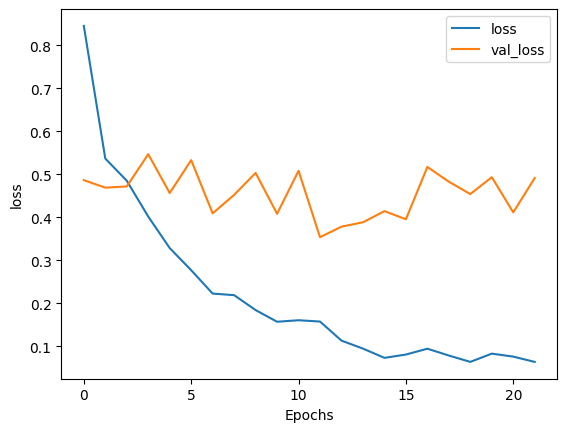

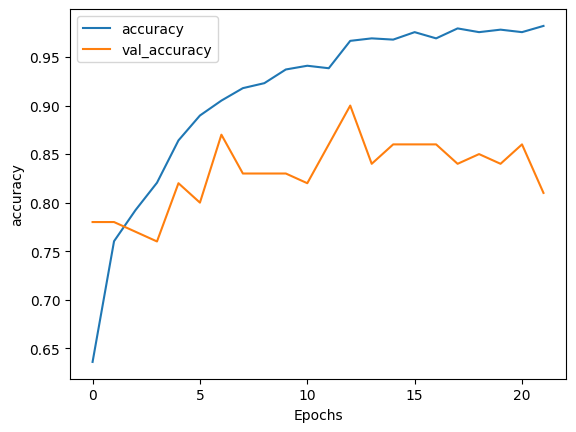

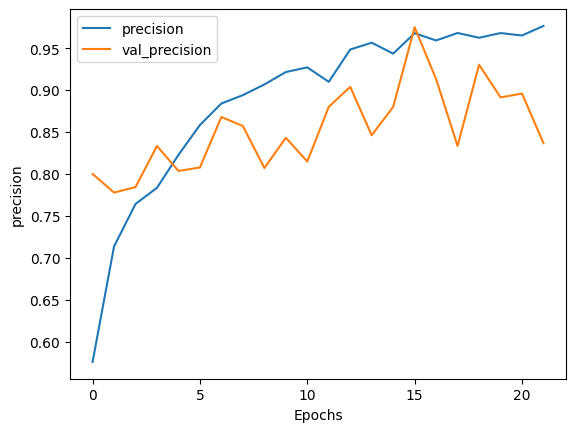

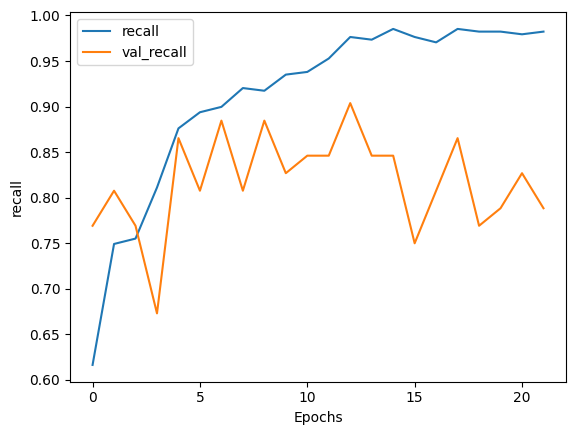

In [ ]:
plotMetrics(VGG16_history, "loss")
plotMetrics(VGG16_history, "accuracy")
plotMetrics(VGG16_history, "precision")
plotMetrics(VGG16_history, "recall")

---
# Testing
---

In [48]:
%cd /content
loadedModel = tf.keras.models.load_model("VGG16-1-gen.keras")

/content


In [49]:
val_loss, val_accuracy, val_precision, val_recall = loadedModel.evaluate(testingSet)

print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9354 - loss: 0.3896 - precision_5: 0.9728 - recall_5: 0.8713
Loss: 0.3930
Accuracy: 0.9333
Precision: 0.9655
Recall: 0.8750


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


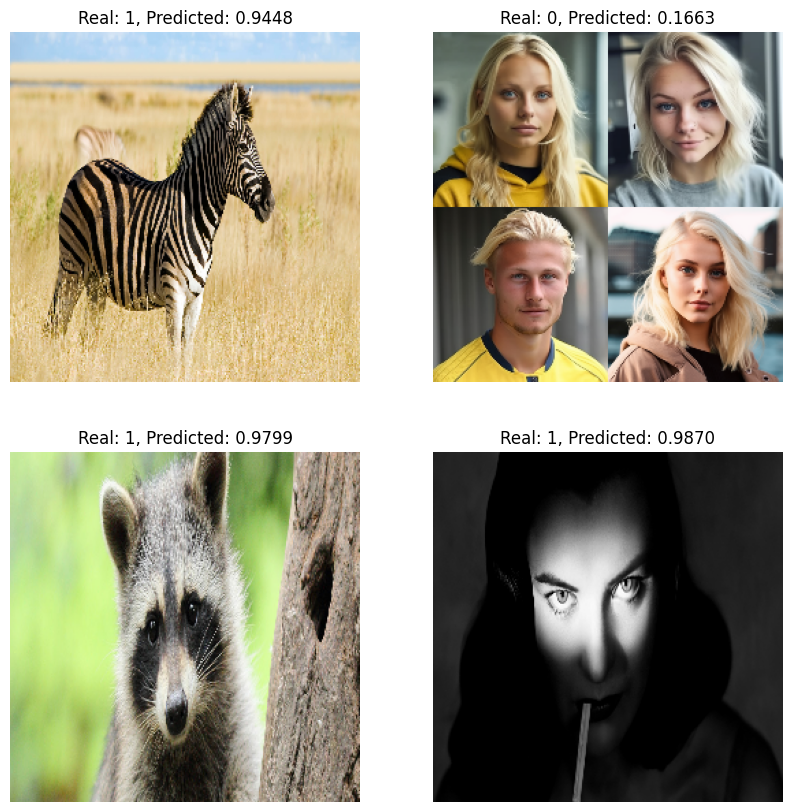

In [50]:
plt.figure(figsize=(10, 10))
for images, labels in trainingSet.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        result = loadedModel.predict(np.expand_dims(np.array(images[i]), axis = 0))
        plt.title(f"Real: {int(labels[i])}, Predicted: {result[0 ,0]:.4f}")
        plt.axis("off")

mkdir: cannot create directory ‘/content/imgTest’: File exists
/content/imgTest


Saving wp-image-207395395jpg.jpg to wp-image-207395395jpg (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


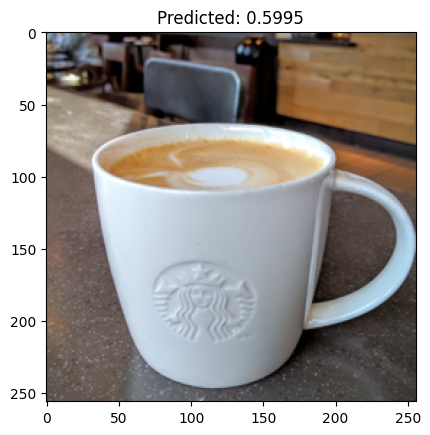

In [51]:
!mkdir /content/imgTest
%cd /content/imgTest
uploaded = files.upload()
uploadName = list(uploaded.keys())[0]

with pimg.open(uploadName) as img:
  res = img.resize(imgDim).convert('RGB')
  result = loadedModel.predict(np.expand_dims(np.array(res), axis = 0))
  plt.title(f"Predicted: {result[0 ,0]:.4f}")
  imgplot = plt.imshow(res)
  plt.show()